# Using Correlations

### Introduction

In the last sections, we saw how we can use recursive feature selection to reduce the number of features while retaining a relatively accurate model.  The mechanism of recursive feature selection is quite automatic - that is, we simply go one by one and try to see which feature remoal would least hurt our score.  

The goal is to use some of our own judgment to find features which are multicollinear and remove them.

### Becoming more picky

The automatic nature of recursive features selection works well when dealing with a large number of features.  However we can further try reducing features, as well as gain insight into our model by examining which features are highly correlated with others.

Let's use the boston housing dataset this time, then use recrusive feature selection, and then move onto reduce our number of features using correlations.

In [1]:
from sklearn.datasets import load_boston
data = load_boston()

from sklearn.model_selection import train_test_split
X = data['data']
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X.shape

(506, 13)

This time our dataset has thirteen features and 506 observations.  Now let's perform RFE to narrow down our number of features.

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV, RFE
estimator = LinearRegression(n_jobs=-1)
initial_rfe = RFECV(estimator, step=1, cv=3)
X_train_rfe = initial_rfe.fit_transform(X_train,y_train)

In [3]:
initial_rfe.grid_scores_

array([0.15930715, 0.50937036, 0.52655376, 0.56084288, 0.60430819,
       0.69128151, 0.69414701, 0.69402056, 0.69291292, 0.69403442,
       0.69918368, 0.70153077, 0.70355539])

It looks like 6 features is our number, as we still have a score of `.6912`.  Let's discover which six features were selected.

In [4]:
estimator = LinearRegression(n_jobs=-1)
rfe = RFE(estimator, 6)
X_train_rfe = rfe.fit_transform(X_train,y_train)

In [5]:
estimator.fit(X_train_rfe, y_train)
x_test_rfe = rfe.transform(X_test)
estimator.score(x_test_rfe, y_test)

0.7061887969432579

Now we can again use the `support_` method.

In [8]:
import numpy as np
selected_feat_names = np.array(data['feature_names'])[rfe.support_]

selected_feat_names

array(['CHAS', 'NOX', 'RM', 'DIS', 'PTRATIO', 'LSTAT'], dtype='<U7')

Now that we have selected our most important features, we can begin to explore the similarities between the data to see if it makes sense to reduce our data further.

### Exploring Correlations

To see which features may still be redundant, we should explore correlations between the data.

First we select the top six features.

In [18]:
X = data['data']

In [9]:
reduced_X = X[:, rfe.support_]

In [10]:
import pandas as pd
df_reduced = pd.DataFrame(reduced_X, columns = selected_feat_names)

Now we can graph the associations of each feature with the others by creating a scatter matrix.

scatter matrix


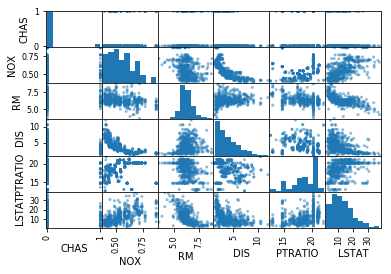

In [36]:
pd.plotting.scatter_matrix(df_reduced)
print('scatter matrix')

And we can express this show this mathematically with the correlation.

In [38]:
df_reduced.corr(method = 'pearson')

,CHAS,NOX,RM,DIS,PTRATIO,LSTAT
CHAS,1.000000,0.091203,0.091251,-0.099176,-0.121515,-0.053929
NOX,0.091203,1.000000,-0.302188,-0.769230,0.188933,0.590879
RM,0.091251,-0.302188,1.000000,0.205246,-0.355501,-0.613808
DIS,-0.099176,-0.769230,0.205246,1.000000,-0.232471,-0.496996
PTRATIO,-0.121515,0.188933,-0.355501,-0.232471,1.000000,0.374044
LSTAT,-0.053929,0.590879,-0.613808,-0.496996,0.374044,1.000000


Well this correlation metric *almost* captures what we see in our scatter matrix.  More specifically, the pearson correlation, often represented by `r`, captures only the linear relationship between two variables.  So when there is a non-linear relationship, this is not captured.  

For example, take a look at the scatter matrix showing the relationship between `DIS` and `NOX`.  We'll show just a scatter plot of these two variables below.

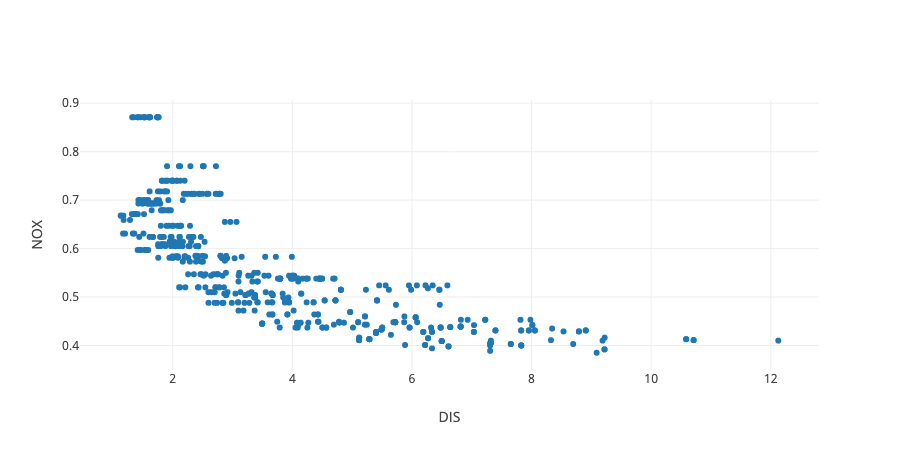

In [44]:
from graph import trace_values, plot
trace = trace_values(df_reduced.DIS, df_reduced.NOX)
plot([trace], layout = {'xaxis': {'title': 'DIS'}, 'yaxis': {'title': 'NOX'}})

So, there does appear to be a relationship between the two variables.  If we look at the correlation, it does indicate this.

In [46]:
from scipy.stats import pearsonr
pearsonr(df_reduced.NOX, df_reduced.DIS)[0]

-0.7692301132258279

But we can see any even stronger relationship, if we use a metric like `spearmanr`.  

In [48]:
from scipy.stats import spearmanr
corr = np.round(spearmanr(df_reduced.NOX, df_reduced.DIS).correlation, 4)
corr

-0.88

So we can see that by using the spearman correlation, we detect a stronger relationship.  The reason why is because the spearman correlation detects both linear and non-linear relationships, and a non-linear relationship is primarily what we see.  Let's dive a little bit deeper into how spearman r captures a non-linear relationship.

### The spearman correlation

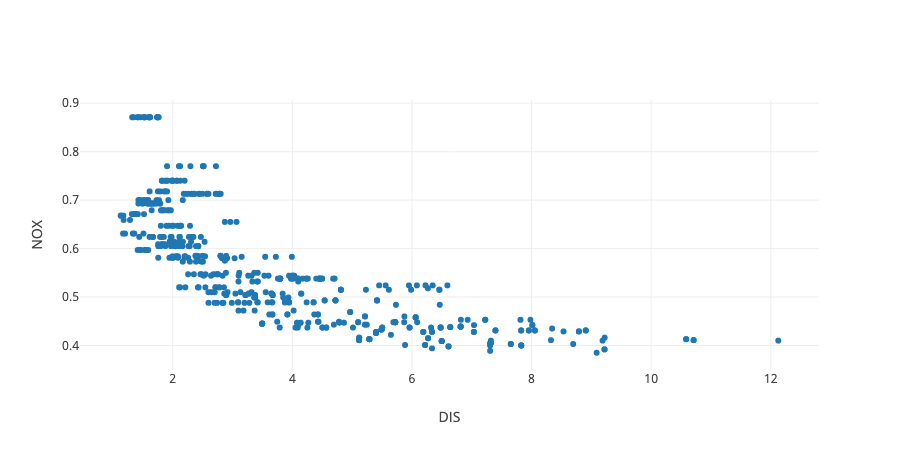

In [49]:
from graph import trace_values, plot
trace = trace_values(df_reduced.DIS, df_reduced.NOX)
plot([trace], layout = {'xaxis': {'title': 'DIS'}, 'yaxis': {'title': 'NOX'}})

And now let's change to plotting the rank the two variables.

In [11]:
df_reduced.DIS.rank()[:4]

0    323.0
1    370.5
2    370.5
3    421.0
Name: DIS, dtype: float64

In [12]:
df_reduced.NOX.rank()[:4]

0    261.0
1    150.5
2    150.5
3    137.0
Name: NOX, dtype: float64

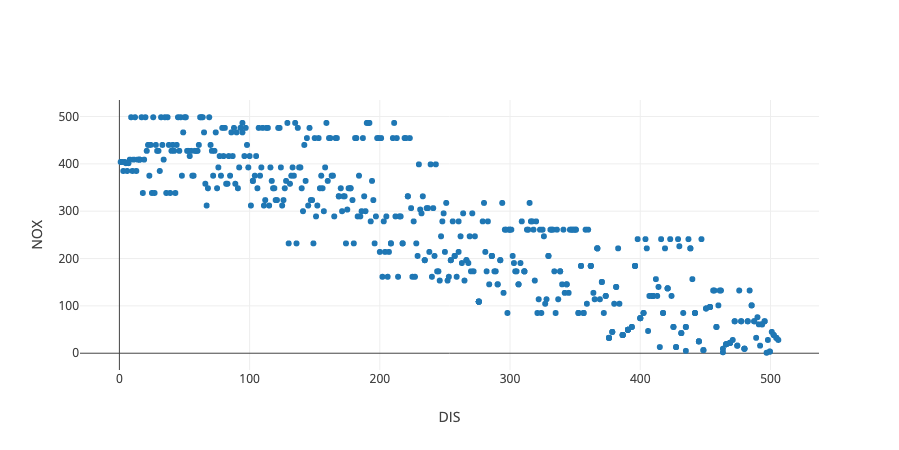

In [50]:
from graph import trace_values, plot
trace = trace_values(df_reduced.DIS.rank(), df_reduced.NOX.rank())
plot([trace], layout = {'xaxis': {'title': 'DIS'}, 'yaxis': {'title': 'NOX'}})

So we can see that by calculating the rank, we transform the relationship to being linear, and now the correlation would be stronger.

In [51]:
from scipy.stats import pearsonr
pearsonr(df_reduced.NOX.rank(), df_reduced.DIS.rank())[0]

-0.8800148627197036

And this is precisely what the spearman correlation does.

In [53]:
from scipy.stats import spearmanr
spearmanr(df_reduced.NOX, df_reduced.DIS)[0]

-0.8800148627197037

So going forward we'll take a look at the spearman correlations (the rank correlation) instead of the rank correlations.  And we can look at the spearman correlations between all variables with the following.

In [54]:
df_reduced.corr(method = 'spearman')

,CHAS,NOX,RM,DIS,PTRATIO,LSTAT
CHAS,1.000000,0.068426,0.058813,-0.080248,-0.136065,-0.050575
NOX,0.068426,1.000000,-0.310344,-0.880015,0.391309,0.636828
RM,0.058813,-0.310344,1.000000,0.263168,-0.312923,-0.640832
DIS,-0.080248,-0.880015,0.263168,1.000000,-0.322041,-0.564262
PTRATIO,-0.136065,0.391309,-0.312923,-0.322041,1.000000,0.467259
LSTAT,-0.050575,0.636828,-0.640832,-0.564262,0.467259,1.000000


We can represent it as a scatter matrix.

hola


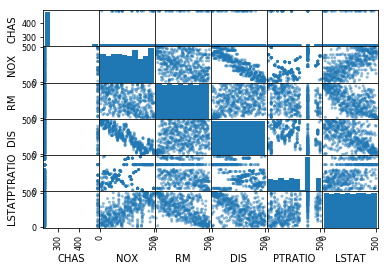

In [257]:
df = pd.DataFrame(reduced_X, columns = selected_feat_names)
plot = pd.plotting.scatter_matrix(df.rank())
print('hola')

# Working with Dendrograms

### Introduction

In the last lesson, we saw how we can detect variables that are associated with each other by using correlations.  The motivation for examining the correlations between variables is that if two features are correlated, we can likely remove one of them with suffering a significant decrease in our model's accuracy.  And by reducing the number of features, we see our standard benefits of a more understable model, a decrease in variance, and a reduction in multicollinearity.

In the last section, we also saw two different types of correlations.  The pearson correlation which measured strictly the strength of a linear relationship between variables, and the spearman correlation or rank correlation, which also captured non-linear relationships.

As mentioned, we'll focus on the spearman correlation going forward.

### Plotting Correlations with Dendrograms

Now previously, we plotted both our relationships among variables with scatter plots.  In this section, we'll use a dendrogram to see if two variables are assosicated with one another.  Ok, so let's start by plotting our scatter matrix of the rank of the features.

In [78]:
import pandas as pd
df_boston_housing = pd.read_csv('boston_housing_reduced.csv').iloc[:, 1:]
reduced_X = df_boston_housing.iloc[:, 0:-1]
y = df_boston_housing.iloc[:, -1]

hola


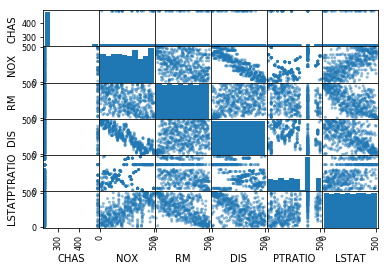

In [65]:
df = pd.DataFrame(reduced_X, columns = selected_feat_names)
plot = pd.plotting.scatter_matrix(df.rank())
print('hola')

So from the scatter matrix, we see the following: 

* LSTAT appears to have the strongest correlation with other variables like DIS, RM, and NOX.  
* And NOX and DIS also appear to be correlated with each other. 

And now let's produce our dendrogram, and then we'll explain what it shows.

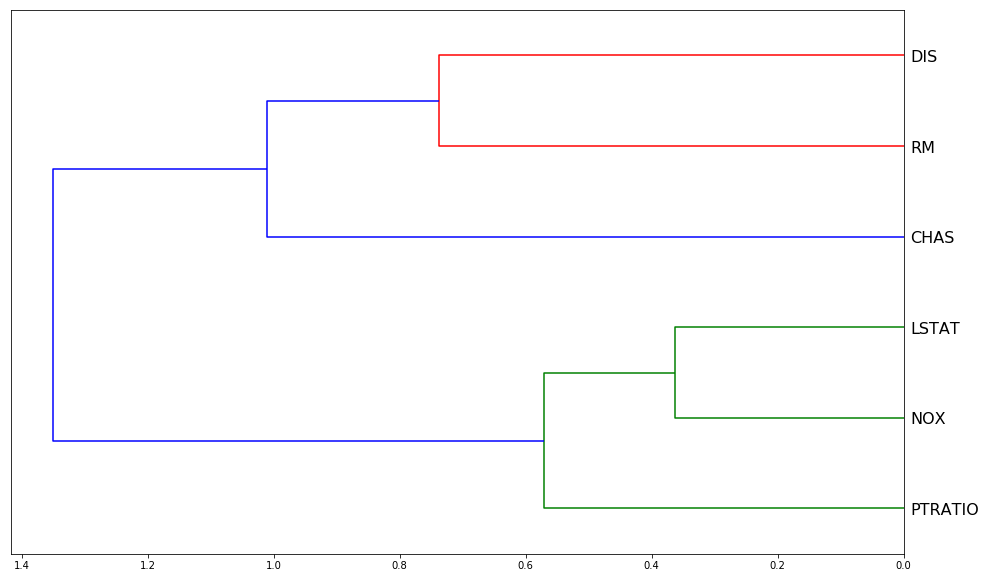

In [56]:
import scipy.cluster.hierarchy as hc
corr = df_reduced.corr(method = 'spearman')
corr_condensed = hc.distance.squareform(1 - corr)
z = hc.linkage(corr_condensed, method = 'average')

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels = selected_feat_names, orientation = 'left', leaf_font_size=16)

Our dendrogram is clustering our features, based on which ones have the highest spearman correlations.  If two  features are connected at a lower level, they have a higher correlation than those connected at a higher level.  

So with our dendrogram, we see that DIS and RM appear most highly correlated.  And we also see LSTAT's correlation with NOX.  This is a similar conclusion as we saw with our scatter matrix.  The difference is that with this visualization, our dendrogram groups the closely associated features for us, whereas the scatter plots just show us all relationships and leave it to identify the most closely related ones.

### Removing Features

So, looking at the dendrogram above, we should either remove DIS or RM, or LSTAT or NOX.  

LSTAT should be removed as it's correlated with multiple other features, which we see in our scatter matrix.  Both RM and DIS appear only correlated with each other, so let's look to learn more about the domain to see if it can help us decide which to eliminate.

- DIS      weighted distances to five Boston employment centres
- RM       average number of rooms per dwelling
- CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- NOX      nitric oxides concentration (parts per 10 million)
- PTRATIO  pupil-teacher ratio by town
- LSTAT    % lower status of the population

None of these look too similar to the other, so let's just try removing both one at a time, and see what does the best.

In [57]:
selected_feat_names

array(['CHAS', 'NOX', 'RM', 'DIS', 'PTRATIO', 'LSTAT'], dtype='<U7')

First let's remove, LSTAT, our last feature.

In [58]:
removed_LSTAT_X = reduced_X[:, :-1]

X_train_removed_L, X_test_removed_L, y_train_removed_L, y_test_removed_L = train_test_split(removed_LSTAT_X , y, test_size=0.33, random_state=42)

In [59]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_removed_L, y_train_removed_L)
model.score(X_test_removed_L, y_test_removed_L)

0.629277704596262

This is a significant drop, so let's now try removing DIS.

In [60]:
first_half = reduced_X[:, :3]
second_half = reduced_X[:, 4:]
combined = np.column_stack((first_half, second_half))

In [61]:
X_train_wo_dis, X_test_wo_dis, y_train_wo_dis, y_test_wo_dis = train_test_split(combined , y, test_size=0.33, random_state=42)

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_wo_dis, y_train_wo_dis)
model.score(X_test_wo_dis, y_test_wo_dis)

0.6683487981030212

Now this is a little bit of a drop as well, but not as drastic.  When we try removing `RM`, the drop is more significant.

In [62]:
first_half = reduced_X[:, :2]
second_half = reduced_X[:, 3:]
combined_wo_rm = np.column_stack((first_half, second_half))

X_train_wo_rm, X_test_wo_rm, y_train_wo_rm, y_test_wo_rm = train_test_split(combined_wo_rm , y, test_size=0.33, random_state=42)

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_wo_rm, y_train_wo_rm)
model.score(X_test_wo_rm, y_test_wo_rm)


0.6333485013115527

Ok, so at this point, we need to make a judgment call as to whether reducing DIS is worth the reduction in our score.

But notice, that by going through our procedures, we were able to outperform our RFECV algorithm.  It scored lower when reducing down to five features, with a score of .604.

In [80]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV
estimator = LinearRegression(n_jobs=-1)
initial_rfe = RFECV(estimator, step=1, cv=3)
X_train_rfe = initial_rfe.fit_transform(X_train,y_train)
initial_rfe.grid_scores_

array([0.15930715, 0.50937036, 0.52655376, 0.56084288, 0.60430819,
       0.69128151, 0.69414701, 0.69402056, 0.69291292, 0.69403442,
       0.69918368, 0.70153077, 0.70355539])

### The point of it all

So by using scatter matrices and our dendrogram we were able to discover how to produce a less significant drop by removing the DIS score.  At the very least, by being to prioritize our most important features, we are able to prioritize our time for further feature engineering and domain exploration.  Let's look at our dendrogram again.

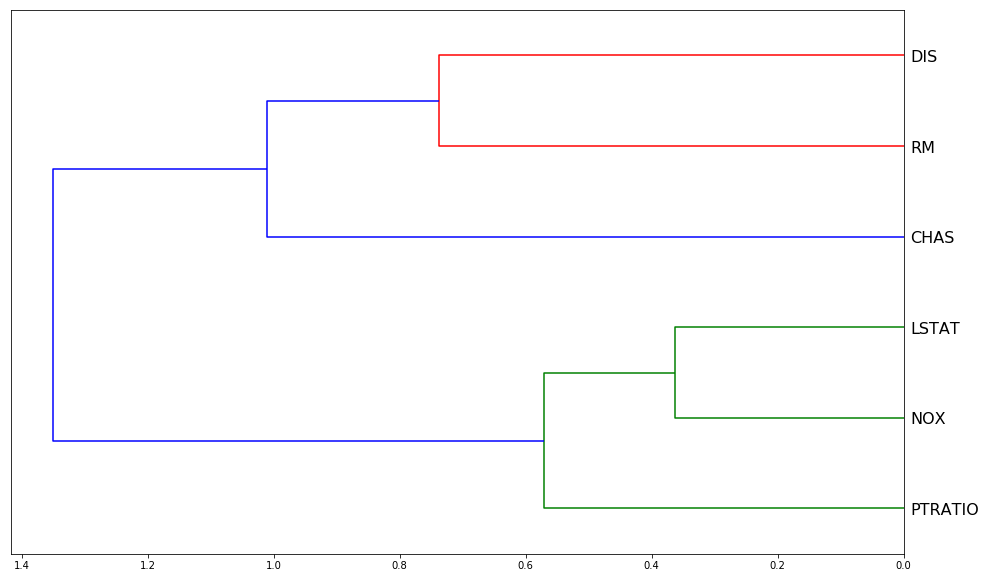

In [64]:
import scipy.cluster.hierarchy as hc
corr_condensed = hc.distance.squareform(1 - corr)
z = hc.linkage(corr_condensed, method = 'average')

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels = selected_feat_names, orientation = 'left', leaf_font_size=16)

So by knowing that distance from employment centers and number of rooms are related, and that lower status percentage and noxious gas percentages are related, we can start to brainstorm if there might be other aspects that capture similar entities. 

In addition, because the charles river feature, CHAS seems to be both significant and not very correlated to others, we may consider if there are other landmark or geographic data we could explore that is currently not being captured in our model.

### Summary

In this lesson, we saw a new visualization called dendrograms.  We used dendrograms to cluster our features based on the relationships between them.  This allowed us to develop candidates for removal, which we confirmed whether or not the features were good to remove via trial and error.  We saw that by using this technique, we produced better potential reductions in scores than by using our RFECV mechanism from sklearn.

And using the dendrogram, also gave us a better understanding of our dataset by showing us which features were most related.  This is valuable, because if by grouping related features together, we can sometimes think of other missing features that may be lurking variables unincluded in our current model.